In [83]:
# import packages
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import random 
import os
print(os.listdir("../Data.trial"))

['.DS_Store', 'test', 'train']


In [84]:
# define constants
FR = False
Image_W = 128
Image_H = 128
Image_s = (Image_W, Image_H)
Image_C = 3

In [85]:
data_dir = os.listdir("../Data.trial/train") # define your workspace & Create a dataframe from your data
categories = []
for filename in data_dir:
    category = filename.split(".")[0]
    if category == "dog":
            categories.append(1)
    else:
            categories.append(0)

df = pd.DataFrame({
    "filename": data_dir, 
    "category": categories}
)


In [86]:
df.head()
df.tail()

,filename,category
598,cat.220.jpg,0
599,cat.234.jpg,0
600,dog.220.jpg,1
601,dog.234.jpg,1
602,dog.208.jpg,1


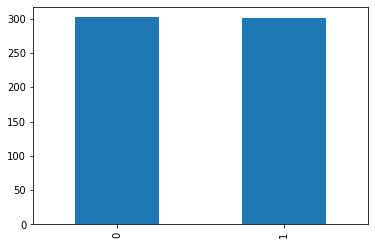

In [87]:
# key figures dataset
df["category"].value_counts().plot.bar()

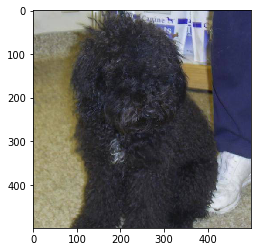

In [88]:
sample = random.choice(data_dir)
image = load_img("../Data.trial/train/"+sample)
plt.imshow(image)

In [89]:
# creat our model 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization 

model_v1 = Sequential()
model_v1.add(Conv2D(32, (3,3), activation = "relu", input_shape=(Image_W,Image_H,Image_C)))
model_v1.add(BatchNormalization())
model_v1.add(MaxPooling2D(pool_size=(2,2)))
model_v1.add(Dropout(0.25))

model_v1.add(Conv2D(64, (3, 3), activation='relu'))
model_v1.add(BatchNormalization())
model_v1.add(MaxPooling2D(pool_size=(2, 2)))
model_v1.add(Dropout(0.25))

model_v1.add(Conv2D(128, (3, 3), activation='relu'))
model_v1.add(BatchNormalization())
model_v1.add(MaxPooling2D(pool_size=(2, 2)))
model_v1.add(Dropout(0.25))

model_v1.add(Flatten())
model_v1.add(Dense(512, activation='relu'))
model_v1.add(BatchNormalization())
model_v1.add(Dropout(0.5))
model_v1.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model_v1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model_v1.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_15 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 64)       

In [90]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau #prevent model from overfitting


In [91]:
earlystop = EarlyStopping(patience=10) #stop the learning after 10 epoch and val_loss not decreased

In [92]:
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_acc",
                                            patience = 2,
                                            verbose = 1, 
                                            factor = 0.5,
                                            min_lr = 0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [93]:
df["category"] = df["category"].replace({0:"cat",1:"dog"})

In [94]:
df.head()
df.tail()

,filename,category
598,cat.220.jpg,cat
599,cat.234.jpg,cat
600,dog.220.jpg,dog
601,dog.234.jpg,dog
602,dog.208.jpg,dog


In [95]:
train_df,validate_df = train_test_split(df, test_size = 0.20, random_state=42)
train_df.head()

,filename,category
9,dog.173.jpg,dog
426,cat.281.jpg,cat
525,cat.193.jpg,cat
188,dog.42.jpg,dog
131,dog.229.jpg,dog


In [96]:
train_df = train_df.reset_index(drop=True) #reset the indexing in the train data
train_df.head()
validate_df = validate_df.reset_index(drop=True)
validate_df.head()

,filename,category
0,dog.176.jpg,dog
1,dog.29.jpg,dog
2,dog.223.jpg,dog
3,dog.161.jpg,dog
4,cat.265.jpg,cat


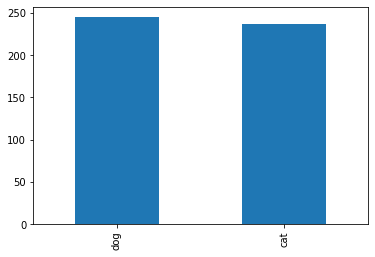

In [97]:
train_df["category"].value_counts().plot.bar()

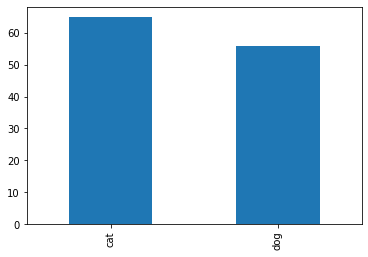

In [98]:
validate_df["category"].value_counts().plot.bar()

In [99]:
total_train = train_df.shape[0] #tuple that gives you an indication of the number of dimensions in the array (list which is not editable)
total_validate = validate_df.shape[0]
batch_size = 15

In [100]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../Data.trial//train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_s,
    class_mode='categorical',
    batch_size=batch_size
)

Found 482 validated image filenames belonging to 2 classes.


In [101]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../Data.trial/train", 
    x_col='filename',
    y_col='category',
    target_size=Image_s,
    class_mode='categorical',
    batch_size=batch_size
)


Found 120 validated image filenames belonging to 2 classes.


/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [113]:
epochs =  50 
history = model_v1.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
32/32 [==============================] - 10s 301ms/step - loss: 0.5482 - accuracy: 0.7173 - val_loss: 1.1459 - val_accuracy: 0.5500
Epoch 2/50
32/32 [==============================] - 10s 320ms/step - loss: 0.5972 - accuracy: 0.7259 - val_loss: 0.9979 - val_accuracy: 0.6250
Epoch 3/50
32/32 [==============================] - 11s 343ms/step - loss: 0.5494 - accuracy: 0.7109 - val_loss: 0.6666 - val_accuracy: 0.6750
Epoch 4/50
32/32 [==============================] - 10s 320ms/step - loss: 0.4929 - accuracy: 0.7859 - val_loss: 0.6976 - val_accuracy: 0.7083
Epoch 5/50
32/32 [==============================] - 12s 373ms/step - loss: 0.5487 - accuracy: 0.7580 - val_loss: 0.6807 - val_accuracy: 0.6750
Epoch 6/50
32/32 [==============================] - 12s 367ms/step - loss: 0.5531 - accuracy: 0.7409 - val_loss: 0.8985 - val_accuracy: 0.6500
Epoch 7/50
32/32 [==============================] - 11s 335ms/step - loss: 0.5585 - accuracy: 0.7473 - val_loss: 0.8732 - val_accuracy: 0.6167

In [114]:
model_v1.save_weights("model.v1")

<function matplotlib.pyplot.show(*args, **kw)>

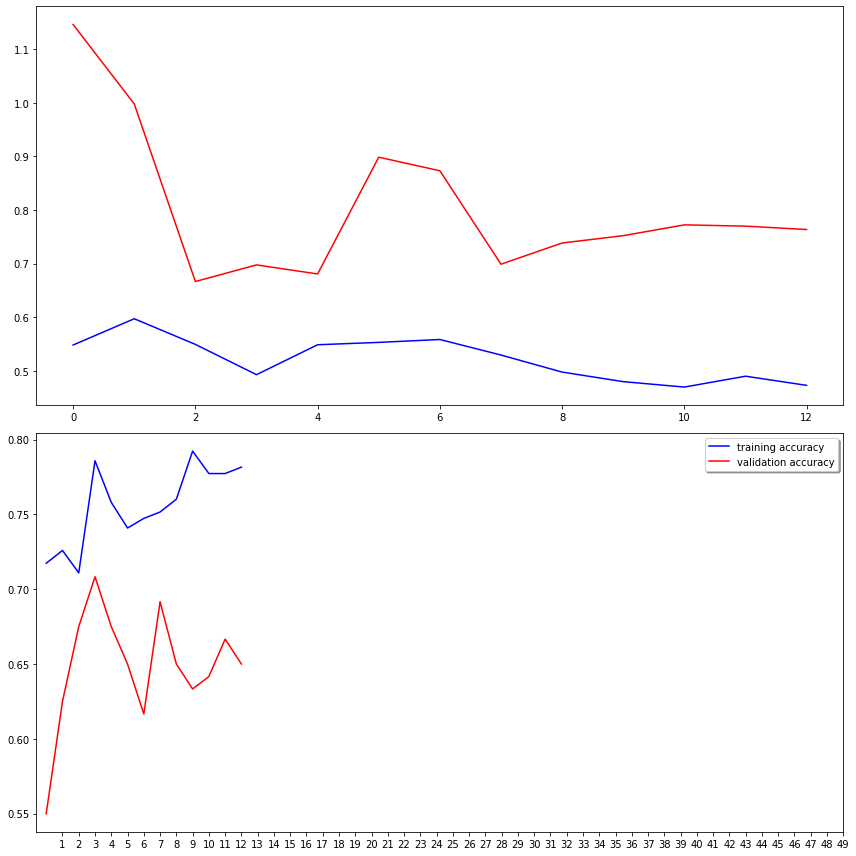

In [115]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
ax1.plot(history.history["loss"], color ='b', label = "training loss")
ax1.plot(history.history["val_loss"], color ='r', label = "validation loss")

ax2.plot(history.history["accuracy"], color ='b', label = "training accuracy")
ax2.plot(history.history["val_accuracy"], color ='r', label = "validation accuracy")
ax2.set_xticks(np.arange(1,epochs,1))

legend = plt.legend(loc="best", shadow =True)
plt.tight_layout()
plt.show

In [128]:
test_dir = os.listdir("../Data.trial/test") 
test_df = pd.DataFrame({
    'filename': test_dir
})
test_df.head()
nb_samples = test_df.shape[0]

In [129]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../Data.trial/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=Image_s,
    batch_size=batch_size,
    shuffle=False
)

Found 100 validated image filenames.


In [141]:
predict = model_v1.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [159]:
test_df["category"]= predict
test_df["category_class"] = np.argmax(predict, axis =1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df["category_class"] = test_df["category_class"].replace(label_map)

In [160]:
test_df.head()

,filename,category,category_class
0,63.jpg,0.395876,dog
1,77.jpg,0.045524,dog
2,88.jpg,0.110182,dog
3,89.jpg,0.833564,cat
4,76.jpg,0.466959,dog


<function matplotlib.pyplot.show(*args, **kw)>

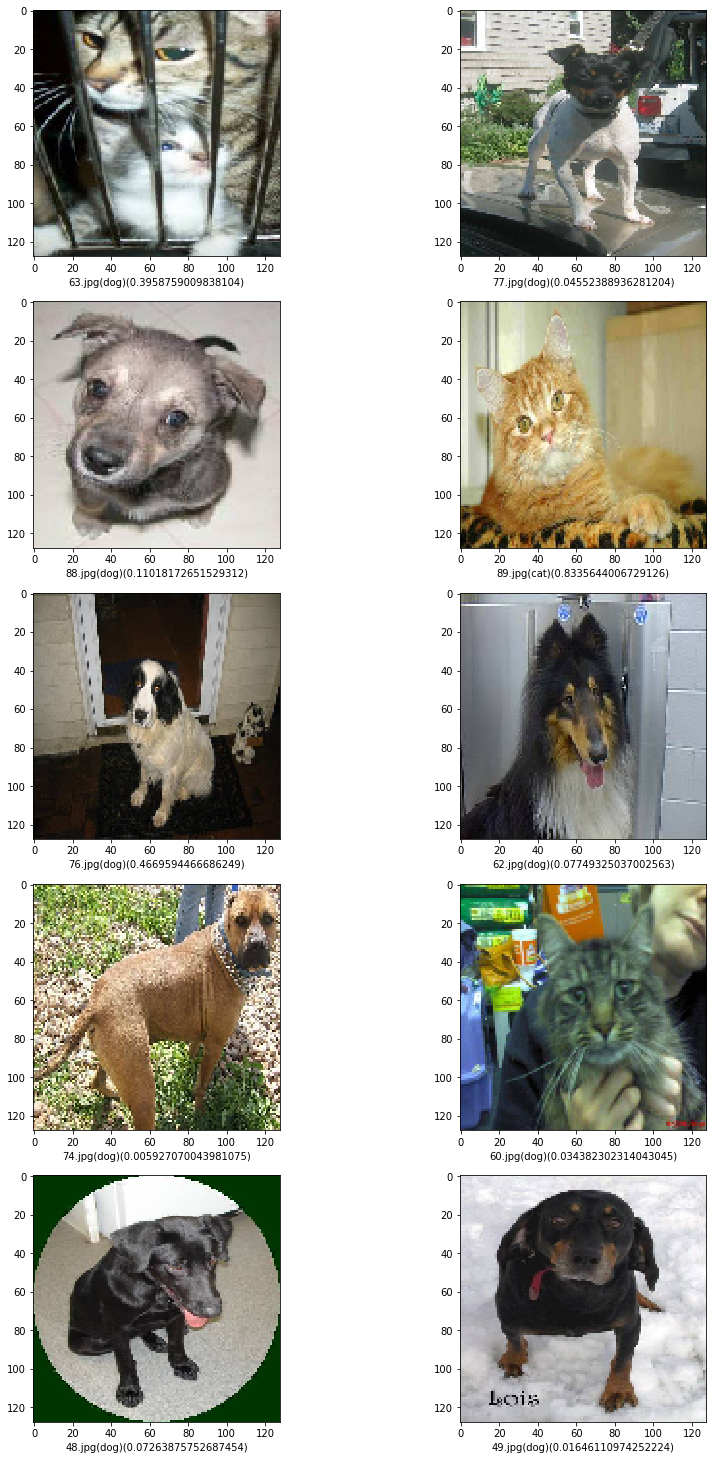

In [170]:
sample_test = test_df.head(10)
sample_test.head()
plt.figure(figsize=(12,24))
for index,row in sample_test.iterrows():
    filename=row["filename"]
    category = row["category_class"]
    prob = row["category"]
    img = load_img("../Data.trial/test/" + filename , target_size = Image_s)
    plt.subplot(6,2,index+1)
    plt.imshow(img)
    plt.xlabel(filename +  "("+ "{}".format(category) + ")" + "("+ "{}".format(prob) + ")")

    plt.tight_layout()
plt.show